In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-ultrasound-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209633%2F2021025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240318%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240318T234720Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2f9f832248f4b8221b63e8aef6ff6413b443231f8a47eae01bca553c39a16e1634ae344eabbc1c37eaa358599789f3d5760c950a07ba9d1a8f0b036fcbd85ef1f59e6d348c8fe758d07e0046cd29aa131cb3c6801bb5f966a457816552868a6d29b92bff4539180191d488bae8e3d8cdeb5d76e6e9746d6872fc70b37e637ca67910e97aa7e09f2022a4b159aee7f406260d792f9cfcc4da0c33c9ef9f917a8e93f15198053e4d2d6dd61f79eb4e5ec6a5b543aab333f9905aa516c527f4548d685749a3bc8b389e82244e5c0100a2e63d20ab44144a217a1750655231c4cff8ab6eb8307aba310daa123e5f9d7f252135b0e8c36e5bc9ab4c1d8b720638377d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 204421470 bytes downloaded
Downloaded and uncompressed: breast-ultrasound-images-dataset
Data source import complete.


In this code i have trained segmentation model to segment tumor in breast MRI, also tumor can be either benign or malignant.

This code first merse all masks and labels, to create single mask representing tumor and its type.

Segmentation model is used to segment the tumor in Breast MRI.

In [2]:
import numpy as np # linear algebra
import os

# Dataset

## Load Classes Names

In [3]:
BASE_PATH = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
unique_classes = []
for path in os.listdir(BASE_PATH):
    unique_classes.append(path)
print(unique_classes)

['normal', 'malignant', 'benign']


## assign index to classes

In [4]:
class_index = [unique_classes[1], unique_classes[0], unique_classes[2]]
for c in class_index:
    print(c, "-", class_index.index(c))

malignant - 0
normal - 1
benign - 2


# Loading images and masks paths

because images it self take lot of space, right now we dont need images.

In [5]:
images = []
masks = []
labels = []
for folder in os.listdir(BASE_PATH):
    class_path = os.path.join(BASE_PATH, folder)
    for img in os.listdir(class_path):
        if "_mask" not in img:
            img_path = os.path.join(class_path, img)
            msk_path = img_path.replace(".png", "_mask.png")
            # check if mask exist
            if os.path.exists(msk_path):
                images.append(img_path)
                masks.append(msk_path)
                labels.append(folder)

In [6]:
print(len(images))

780


In [6]:
images[0]

'/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/normal/normal (87).png'

# Data Loading and Preprocessing

In [7]:
input_images_size = 256
channel = 1

In [8]:
import cv2
import scipy
import scipy.ndimage


def load_image(img_path):
    """ Load single image as Grayscale
    """
    # load image as grayscale
    img = cv2.imread(img_path, 0)
    return img

def padding(img, msk):
    """ Pad images to make them square
    """
    size = np.max(img.shape)

    offset_x = (size-img.shape[0])//2
    offset_y = (size-img.shape[1])//2

    blank_image = np.zeros((size, size))
    blank_mask = np.zeros((size, size))

    blank_image[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = img
    blank_mask[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = msk
    return blank_image, blank_mask

def resize_mask(mask):
    """Resize mask, its different because mask pixel value can change because of resize
    """
    new_size = np.array([input_images_size, input_images_size]) / mask.shape
    mask = scipy.ndimage.interpolation.zoom(mask, new_size)
    return mask

def resize(img):
    """Resize image
    """
    img = cv2.resize(img, (input_images_size, input_images_size))
    return img

def preprocess(img):
    """Image preprocessing
    Normalize image
    """
    img = img/255.0
    return img

def inverse_preprocess(img):
    """Inverse of preprocessing
    """
    img = img*255
    return img

def load_data(img_path, msk_path, label):
    """Load image, mask and repalce mask value with class index
    0 = normal
    1 = benign
    2 = malignant
    """
    img = load_image(img_path)
    msk = load_image(msk_path)
    img, msk = padding(img, msk)
    label_indx = class_index.index(label)
    msk[msk == 255] = 1
    msk = msk.astype("uint8")
    img = resize(img)
    msk = resize_mask(msk)
    new_mask = np.zeros((input_images_size, input_images_size, 2))
    if label_indx != 0:
        new_mask[:, :, label_indx-1] = msk
#     print(np.unique(msk), label, label_indx)
    return img, new_mask

def load_batch(images, masks, labels):
    """Load Batch of data
    """
    batch_x = []
    batch_y = []
    for i, m, l in zip(images, masks, labels):
        img, msk = load_data(i, m, l)
        img = preprocess(img)
        batch_x.append(img)
        batch_y.append(msk)
    return np.array(batch_x), np.array(batch_y)

<ipython-input-8-fafeea0bcd96>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 216.119873046875 (256, 256)


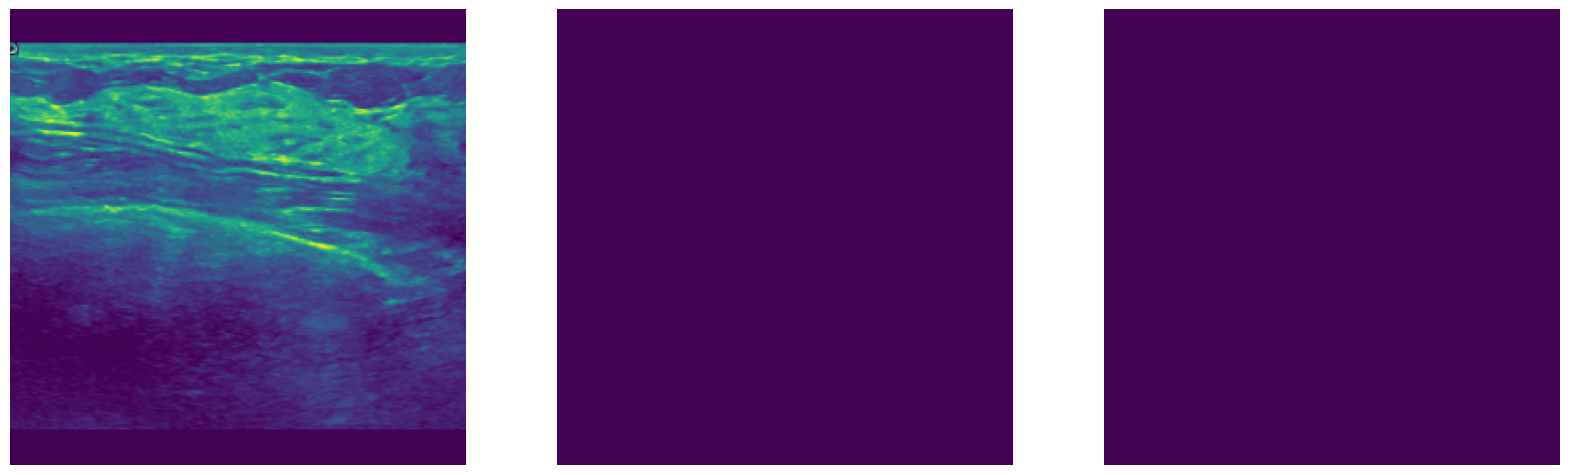

0.0 255.0 (256, 256)


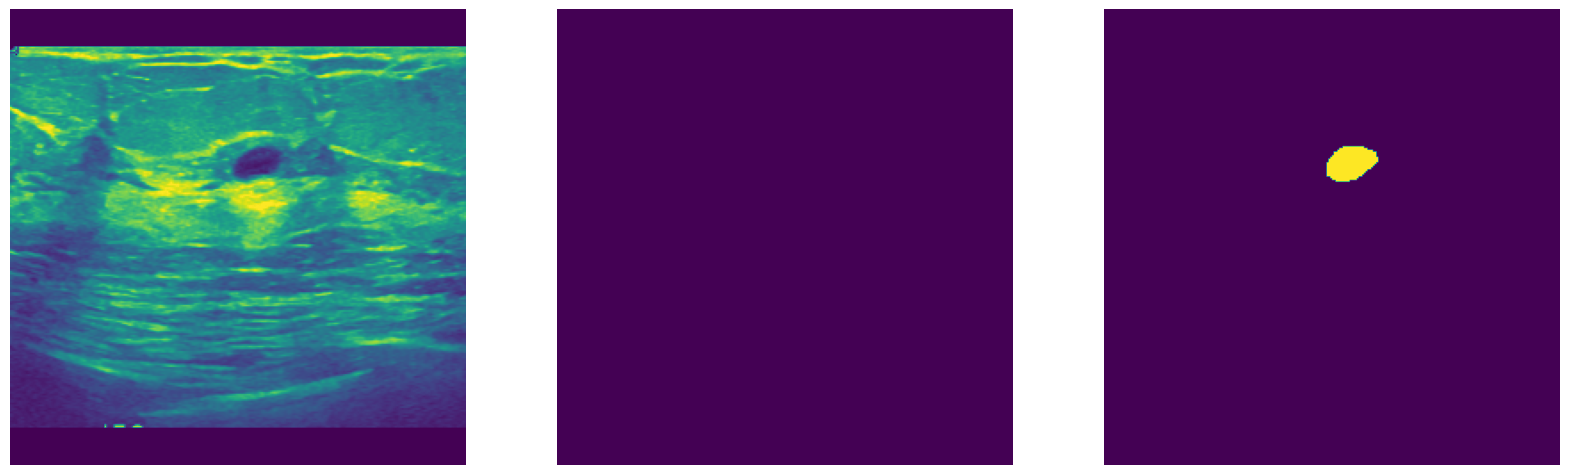

0.0 255.0 (256, 256)


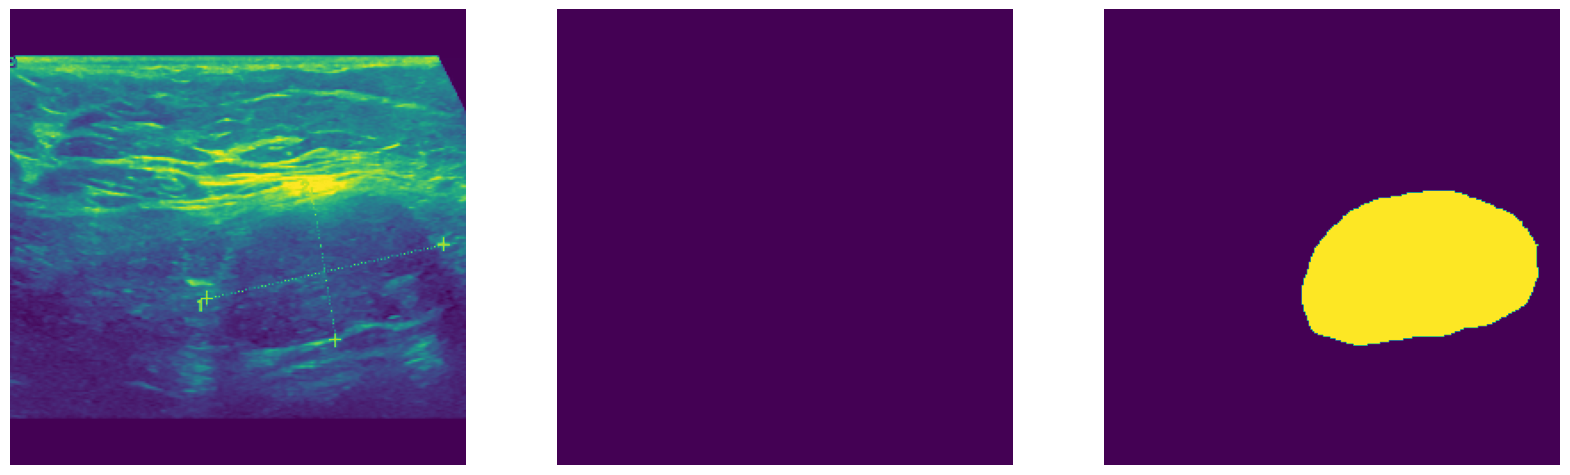

In [9]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(msk[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(msk[:, :, 1])
    plt.show()

In [10]:
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

# Model

In [12]:
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [11]:
import segmentation_models as sm
import tensorflow as tf
sm.set_framework('tf.keras')

sm.framework()

BACKBONE = 'resnet34'
LR = 0.00001
model = sm.Unet(BACKBONE, classes=2, activation="sigmoid",
                input_shape=(input_images_size,
                             input_images_size,
                             channel),
                encoder_weights=None)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

Segmentation Models: using `keras` framework.


# Training

In [12]:
batch_size = 4
history = {"epoch": []}
for e in range(100):
    print("epoch:",e, end=" > ")
    indexes = list(range(len(images)))
    temp_history = {"loss": [],
                   "IOU": [],
                   "F-Score": []}
    for b in range(0, len(images), batch_size):
        bs = b
        be = bs+batch_size
        batch_index = indexes[bs:be]
        batch_x, batch_y = load_batch(images[batch_index], masks[batch_index], labels[batch_index])
        batch_x = np.expand_dims(batch_x, axis=-1)
        batch_y = np.expand_dims(batch_y, axis=-1)
        batch_y = batch_y.astype("float32")
        loss = model.train_on_batch(batch_x, batch_y)
        temp_history["loss"].append(loss[0])
        temp_history["IOU"].append(loss[1])
        temp_history["F-Score"].append(loss[2])
    print("loss", np.round(np.mean(temp_history["loss"]), 4),
         "IOU", np.round(np.mean(temp_history["IOU"]), 4),
         "F-Score", np.round(np.mean(temp_history["F-Score"]), 4))
    history["epoch"].append(temp_history)

model.save_weights("breast_tumor_segmentation")

epoch: 0 > 

<ipython-input-8-fafeea0bcd96>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


loss 1.0584 IOU 0.0131 F-Score 0.0245
epoch: 1 > loss 1.0189 IOU 0.0459 F-Score 0.0743
epoch: 2 > loss 0.9854 IOU 0.1168 F-Score 0.1581
epoch: 3 > loss 0.9544 IOU 0.1673 F-Score 0.2055
epoch: 4 > loss 0.9299 IOU 0.1953 F-Score 0.2276
epoch: 5 > loss 0.9111 IOU 0.2076 F-Score 0.2368
epoch: 6 > loss 0.8952 IOU 0.2174 F-Score 0.2437
epoch: 7 > loss 0.8816 IOU 0.2266 F-Score 0.25
epoch: 8 > loss 0.8688 IOU 0.2325 F-Score 0.2537
epoch: 9 > loss 0.8583 IOU 0.2365 F-Score 0.2562
epoch: 10 > loss 0.8486 IOU 0.239 F-Score 0.2578
epoch: 11 > loss 0.8394 IOU 0.2435 F-Score 0.2608
epoch: 12 > 

KeyboardInterrupt: 

# Testing

<ipython-input-8-fafeea0bcd96>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 216.119873046875 (256, 256)
(256, 256)
1/1 [==============================] - 2s 2s/step


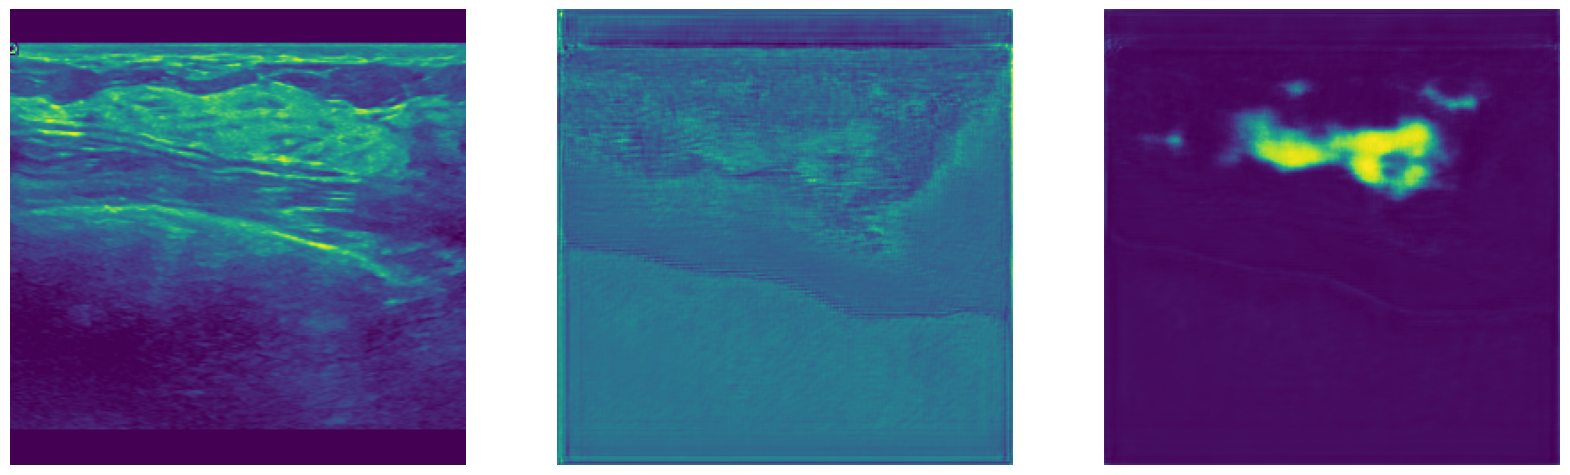

0.0 255.0 (256, 256)
(256, 256)
1/1 [==============================] - 0s 38ms/step


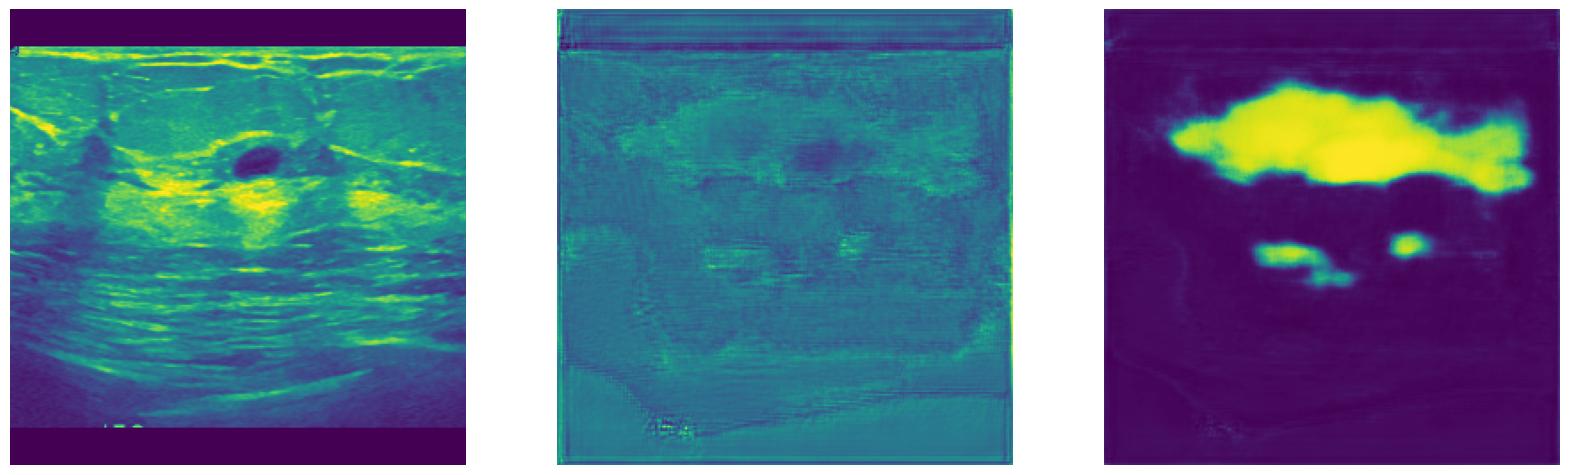

0.0 255.0 (256, 256)
(256, 256)
1/1 [==============================] - 0s 36ms/step


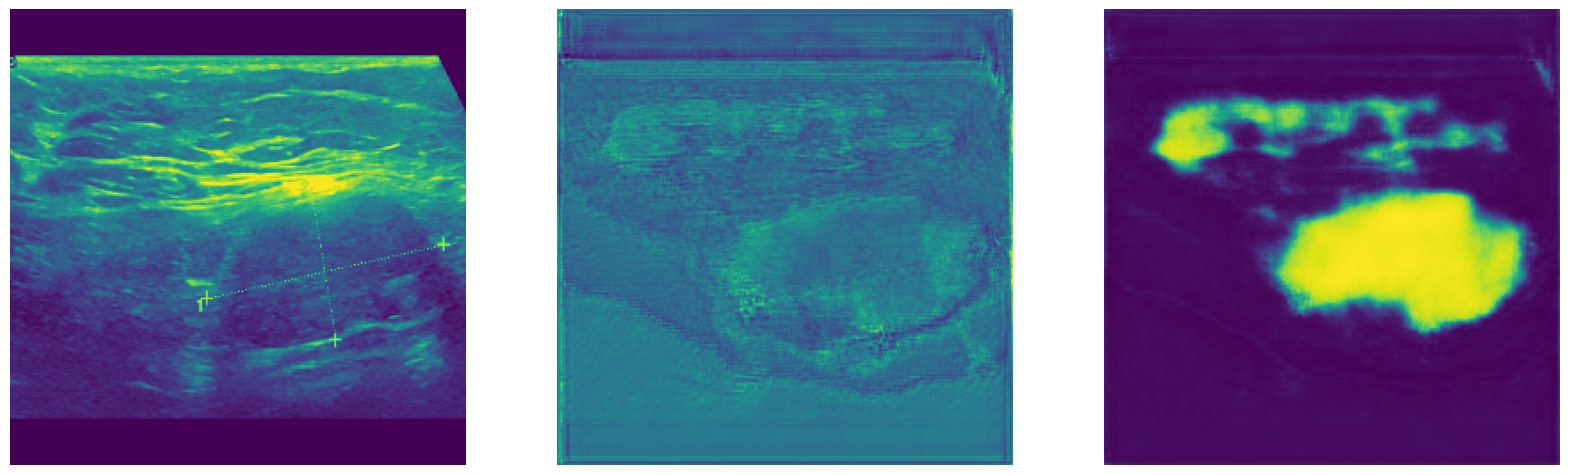

In [13]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    print(img.shape)

    img2 = preprocess(img)
    pred = model.predict(np.array([img2]))
    pred = pred[0]

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(pred[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(pred[:, :, 1])
    plt.show()